This is a notebook that will calculate EIS (Wood and Bretherton 2008) for all CMIP6, CMIP5, and observational data

# Setup

In [33]:
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import xcdat as xc
import xarray as xr

# Load Data

In [ ]:
ERA = "CMIP5"

def get_shared_models(ds1, ds2):
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)

hur2m = xc.open_dataset(f"data/obs/hur-surface_mon_1850-2100_{ERA}_piControl.nc").drop('plev')
ps = xc.open_dataset(f"data/obs/psl_mon_1850-2100_{ERA}_piControl.nc").psl
ta700 = xc.open_dataset(f"data/obs/ta-surface_mon_1850-2100_{ERA}_piControl.nc").ta.drop('plev')
t2m = xc.open_dataset(f"data/obs/tas_mon_1850-2100_{ERA}_piControl.nc").tas

# LOL this is better way to do this but I don't want to figure it out atm
hur2m, ps = get_shared_models(hur2m, ps)
hur2m, ta700 = get_shared_models(hur2m, ta700)
hur2m, t2m = get_shared_models(hur2m, t2m)
hur2m, ps = get_shared_models(hur2m, ps)
hur2m, ta700 = get_shared_models(hur2m, ta700)

data = xr.merge([hur2m, ps, ta700, t2m])
data

In [61]:
# Observations
d2m = xr.open_dataset("data/obs/d2m_mon_ERA5_197901-202212.nc")
ps = xc.open_dataset("data/obs/psl_mon_ERA5_197901-202212.nc").msl
ta700 = xc.open_dataset("data/obs/ta700_mon_ERA5_197901-202212.nc").t
t2m = xr.open_dataset("data/obs/t2m_mon_ERA5_197901-202212.nc")

# Subset time
d2m = d2m.isel(time=np.arange(len(ps.time))).drop("experimentVersionNumber")
t2m = t2m.isel(time=np.arange(len(ps.time))).drop("experimentVersionNumber")
d2m["time"] = ps["time"]
t2m["time"] = ps["time"]

# ds = xc.swap_lon_axis(ds, to=(-180, 180))

# # Regrid d2m and t2m
output_grid = xc.create_grid(ps.latitude.values, ps.longitude.values)
d2m = d2m.regridder.horizontal("d2m", output_grid, tool='xesmf', method='bilinear')["d2m"]
t2m = t2m.regridder.horizontal("t2m", output_grid, tool='xesmf', method='bilinear')["t2m"]
d2m = d2m.rename({"lon": "longitude", "lat": "latitude"})
t2m = t2m.rename({"lon": "longitude", "lat": "latitude"})

# Calculate 2m specific humidity from d2m, ps, and t2m
hur2m=calculate_wvsat(d2m,ps/100)/calculate_wvsat(t2m,ps/100)*100 
hur2m=hur2m.where(hur2m<=100.,100.)

# Rename and Merge
hur2m = hur2m.rename("hur")
ta700 = ta700.rename("ta")
t2m = t2m.rename("tas")
ps = ps.rename("psl")
data = xr.merge([hur2m, ps, ta700, t2m])
data = data.drop("realization")
data

# Calculate EIS

In [62]:
def calculate_wvsat(t,p):
	"""
    wvsat(t): return water vapor saturation mixing ratio (g/kg)
	over liquid for t > 273 K and over ice for t < 273 K
    t is an xarray DataArray, which includes pressures on coordinate 'level'"""

    # air > freezing
    # Source Hyland, R. W. and A. Wexler, Formulations for the Thermodynamic Properties of the saturated 
    # Phases of H2O from 173.15K to 473.15K, ASHRAE Trans, 89(2A), 500-519, 1983.
	p1 = np.exp(  -0.58002206e4 / t + 0.13914993e1 - 0.48640239e-1 * t 
	+ 0.41764768e-4 * t**2. - 0.14452093e-7 * t**3. 
	+ 0.65459673e1 * np.log(t) ) / 100.

# Source : Goff-Gratch, Smithsonian Meteorological Tables, 5th edition, p. 350, 1984
	ei0	   = 6.1071		  # mbar
	T0	   = 273.16		  # freezing point in K
	p2 = 10.**(-9.09718 * (T0 / t - 1.) - 3.56654 * np.log10(T0 / t) + 0.876793 * (1. - t / T0) + np.log10(ei0))
    
	Psat=t*0
	Psat=Psat.where(t < 273,p2)
	Psat=Psat.where(t > 273,p1)

	return Psat/p*18/29.  # return to kg/kg

def calculate_eis(psfc: xr.DataArray, RHsfc: xr.DataArray, Tsfc: xr.DataArray, T700: xr.DataArray, testing: bool = True) -> xr.Dataset:
    """Calculate Estimated Inversion Strength (EIS) and Lower Tropospheric Stability (LTS)
        from data using Mark Zelinka and Li. Wei's method and defined in WOOD AND BRETHERTON 2006

    
    Args:
        psfc (xr.DataArray): Surface Pressure (Pa)
        RHsfc (xr.DataArray): Surface Relative Humidity (%)
        Tsfc (xr.DataArray): Surface Temperature (K)
        T700 (xr.DataArray): 700 hPa Temperature (K)

    Returns:
        EIS (xr.Dataset): dimensions (model, time, lat, lon) (K)
        LTS (xr.Dataset): dimensions (model, time, lat, lon) (K)
    """
    if testing: 
        print("Testing")
        psfc = psfc.isel(time=0)
        RHsfc = RHsfc.isel(time=0)
        Tsfc = Tsfc.isel(time=0)
        T700 = T700.isel(time=0)

    g   = 9.81
    Rd  = 287.04
    Rv  = 461.50
    cpd = 1013.
    Lv  = 2.5e6

    LTS=T700*(700./1000)**(-2./7)-Tsfc*(psfc/100./1000.)**(-2./7)
    
    LTS=LTS.where(psfc>=70000,0.)
    LTS=LTS.where(~np.isnan(LTS),0.)
    LTS=LTS.where(LTS>=0.,0.)
    
    z700 = (Rd*Tsfc/g)*np.log(psfc/70000.)
    zlcl = (20+(Tsfc-273)/5.)*(100-RHsfc)  # meters; hur0 should technically be hurs

    p850 = 850.
    t850 = (Tsfc+T700)/2. # consistent with Wood and Bretherton

    #     qs850 = es_calc(t850-273.15)/(p850*100)*18/29. # temperature (K), pressure (hPa), sat mixing ratio (kg water/kg air)
    qs850 = calculate_wvsat(t850,np.array([p850])) # temperature (K), pressure (hPa), sat mixing ratio (kg water/kg air)
    gamma = g/cpd*(1-(1+Lv*qs850/Rd/t850)/(1+Lv**2*qs850/cpd/Rv/t850**2))
    
    EIS = LTS-gamma*(z700-zlcl)
    
    EIS = EIS.where(psfc>=70000,0.)
    EIS = EIS.where(~np.isnan(EIS),0.)
    return EIS, LTS

In [63]:
EIS, LTS = calculate_eis(psfc=data.psl, RHsfc=data.hur, Tsfc=data.tas, T700=data.ta, testing=False)

In [68]:
# EIS = EIS.rename("eis").to_dataset()
# EIS.to_netcdf(f"data/piControl/EIS_mon_1850-2000_{ERA}_piControl.nc")
EIS.to_netcdf(f"data/obs/EIS_mon_197901-202212_obs.nc")

In [65]:
EIS = EIS.bounds.add_bounds("T")
EIS_anoms = EIS.temporal.departures("eis", "month")

In [69]:
# EIS_anoms.to_netcdf(f"data/piControl/EIS_anoms_mon_1850-2000_{ERA}_piControl.nc")
EIS_anoms.to_netcdf(f"data/obs/EIS_anoms_mon_197901-202212_obs.nc")

In [ ]:
def global_plot_patterns(data, lon, lat, cmap, title="", levels=np.arange(-1.5, 1.5, .1)):
    # plot map of global data with central longitude 180
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    img = ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    ax1.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(title)
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')
    plt.show()

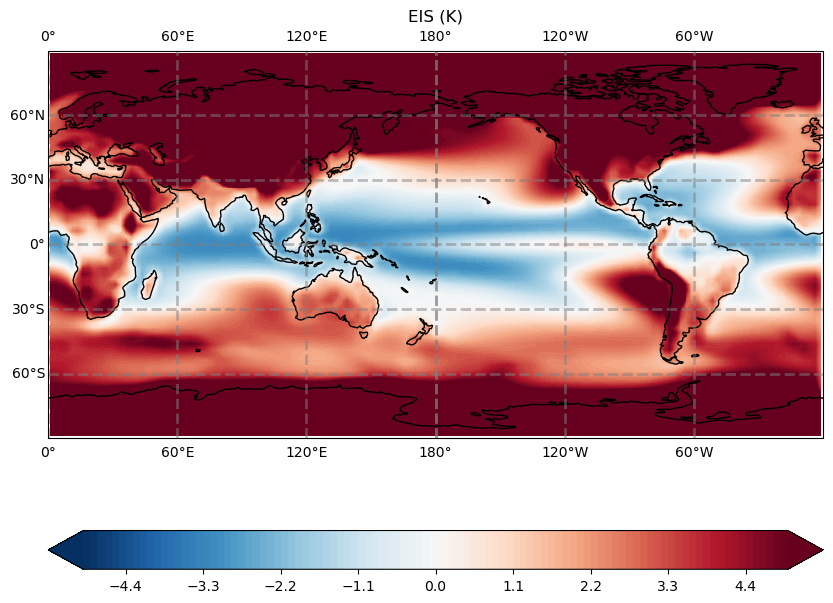

In [ ]:
global_plot_patterns(EIS.mean(["model", "time"]), EIS.lon, EIS.lat, cmap="RdBu_r", levels=np.arange(-5, 5.1, .1), title="EIS (K)")